# Analytics Vidhya Janta Hack

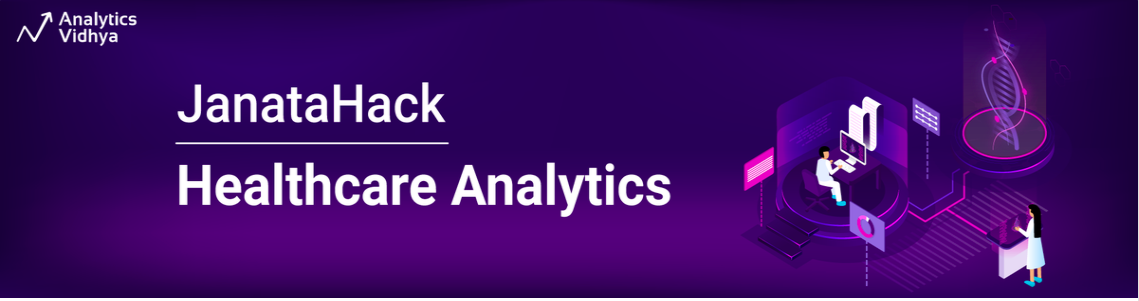

## Problem Statement

Congratulations – you have been hired as Chief Data Scientist of MedCamp – a not for profit organization dedicated in making health conditions for working professionals better. MedCamp was started because the founders saw their family suffer due to bad work life balance and neglected health.

MedCamp organizes health camps in several cities with low work life balance. They reach out to working people and ask them to register for these health camps. For those who attend, MedCamp provides them facility to undergo health checks or increase awareness by visiting various stalls (depending on the format of camp). 

MedCamp has conducted 65 such events over a period of 4 years and they see a high drop off between “Registration” and Number of people taking tests at the Camps. In last 4 years, they have stored data of ~110,000 registrations they have done.

One of the huge costs in arranging these camps is the amount of inventory you need to carry. If you carry more than required inventory, you incur unnecessarily high costs. On the other hand, if you carry less than required inventory for conducting these medical checks, people end up having bad experience.

## The Process:

MedCamp employees / volunteers reach out to people and drive registrations.
During the camp, People who “ShowUp” either undergo the medical tests or visit stalls depending on the format of health camp.
 
## Other things to note:

Since this is a completely voluntary activity for the working professionals, MedCamp usually has little profile information about these people.
For a few camps, there was hardware failure, so some information about date and time of registration is lost.
MedCamp runs 3 formats of these camps. The first and second format provides people with an instantaneous health score. The third format provides information about several health issues through various awareness stalls.

## Favorable outcome:

For the first 2 formats, a favourable outcome is defined as getting a health_score, while in the third format it is defined as visiting at least a stall.
You need to predict the chances (probability) of having a favourable outcome.


## Data Description

### Train.zip contains the following 6 csvs alongside the data dictionary that contains definitions for each variable

Health_Camp_Detail.csv – File containing Health_Camp_Id, Camp_Start_Date, Camp_End_Date and Category details of each camp.

Train.csv – File containing registration details for all the test camps. This includes Patient_ID, Health_Camp_ID, Registration_Date and a few anonymized variables as on registration date.

Patient_Profile.csv – This file contains Patient profile details like Patient_ID, Online_Follower, Social media details, Income, Education, Age, First_Interaction_Date, City_Type and Employer_Category

First_Health_Camp_Attended.csv – This file contains details about people who attended health camp of first format. This includes Donation (amount) & Health_Score of the person.

Second_Health_Camp_Attended.csv - This file contains details about people who attended health camp of second format. This includes Health_Score of the person.

Third_Health_Camp_Attended.csv - This file contains details about people who attended health camp of third format. This includes Number_of_stall_visited & Last_Stall_Visited_Number.



## Test Set

Test.csv – File containing registration details for all the test camps. This includes Patient_ID, Health_Camp_ID, Registration_Date and a few anonymized variables as on registration date.

 

## Train / Test split:

Camps started on or before 31st March 2006 are considered in Train
Test data is for all camps conducted on or after 1st April 2006.


## Sample Submission:

Patient_ID: Unique Identifier for each patient. This ID is not sequential in nature and can not be used in modeling

Health_Camp_ID: Unique Identifier for each camp. This ID is not sequential in nature and can not be used in modeling

Outcome: Predicted probability of a favourable outcome



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lightgbm

In [3]:
!pip install xgboost

In [4]:
heath_camp_detail = pd.read_csv("Health_Camp_Detail.csv", sep=",",na_values=["","#","?","unknown","None"])
patient_profile = pd.read_csv("Patient_Profile.csv", sep =",", na_values=["","#","?","unknown", "None"])
train_data = pd.read_csv("Train.csv", sep=",", na_values=["","#","?","unknown","None"])
test_data = pd.read_csv("test_l0Auv8Q.csv", sep=",", na_values=["", "#","?","unknown","None"])
first_health_camp_attended_data = pd.read_csv("First_Health_Camp_Attended.csv",sep=",", na_values=["","?","#","unknown","None"])
second_health_camp_attended_data = pd.read_csv("Second_Health_Camp_Attended.csv",sep=",",na_values=["","?","#","unknown","None"])
third_health_camp_attended_data = pd.read_csv("Third_Health_Camp_Attended.csv", sep=",",na_values=["","?","#", "unknown", "None"])

In [101]:
# Checking the shape of the data 
print(heath_camp_detail.shape)
print(patient_profile.shape)
print(train_data.shape)
print(test_data.shape)
print(first_health_camp_attended_data.shape)
print(second_health_camp_attended_data.shape)
print(third_health_camp_attended_data.shape)

(65, 15)
(37633, 7)
(75278, 8)
(35249, 8)
(6218, 4)
(7819, 3)
(6515, 4)


In [5]:
def break_down_date(df, date_col, remove_original=False):
    df[date_col] = pd.to_datetime(df[date_col])
    date_col_year = date_col + "_year"
    date_col_month= date_col + "_month"
    date_col_day = date_col + "_day"
    date_col_week = date_col + "_week"
    df[date_col_year] = df[date_col].dt.year
    df[date_col_month] = df[date_col].dt.month
    df[date_col_day] = df[date_col].dt.day
    df[date_col_week] = df[date_col].dt.week
    #remove original date_col is asked to remove
    if remove_original == True:
        df.drop(date_col, axis=1, inplace=True)
    return df

#this return a modified copy of df_test. It doesnot change the input dfs.
def onehotencode_column(df_train, df_test, col_name, remove_original=False, remove_redundant=False):
    onehotencoder = OneHotEncoder(handle_unknown='ignore')
    #create a copies of input df's for modification
    df_train_copy = df_train.copy()
    df_test_copy = df_test.copy()
    
    #ensure type of col_name is set as "category"
    df_train_copy[col_name] = df_train_copy[col_name].astype("category")
    df_test_copy[col_name] = df_test_copy[col_name].astype("category")

    #learn from df_train_copy
    onehotencoder = onehotencoder.fit(df_train_copy.loc[:,[col_name]])
    ohe_cat_col_names = onehotencoder.get_feature_names([col_name])
    
    #modify df_test_copy
    onehotencoded = onehotencoder.transform(df_test_copy.loc[:,[col_name]]).toarray()
    onehotencoded = pd.DataFrame(onehotencoded, columns=ohe_cat_col_names)
    df_test_copy = pd.concat([df_test_copy,onehotencoded],axis=1)
    
    #remove original column if asked to remove
    if remove_original == True:
        df_test_copy.drop(col_name, axis=1, inplace=True)
        
    #remove one redundant column created by one hot encoding if asked to remove
    if remove_redundant == True:
        df_test_copy.drop(ohe_cat_col_names[0], axis=1, inplace=True)
    return df_test_copy


#adding health_camp_type column in the health_camp_detail df

def add_health_camp_type_to_df(heath_camp_detail, first_health_camp_attended_data, second_health_camp_attended_data, third_health_camp_attended_data):
    first_attended_copy = first_health_camp_attended_data.copy()
    second_attended_copy = second_health_camp_attended_data.copy()
    third_attended_copy = third_health_camp_attended_data.copy()
    #1) add health_camp_type column in first_health_camp_attended_data with values as '1'
    first_attended_copy["health_camp_type"] = 1
    #2) add health_camp_type column in second_health_camp_attended_data with values as '2'
    second_attended_copy["health_camp_type"] = 2
    #3) add health_camp_type column in third_health_camp_attended_data with values as '3'
    third_attended_copy["health_camp_type"] = 3
    #4) concat all 3 attended_data dfs 
    fst_attended = pd.concat(
        [
            first_attended_copy.loc[:,['Health_Camp_ID', "health_camp_type"]],
            second_attended_copy.loc[:,['Health_Camp_ID', "health_camp_type"]],
            third_attended_copy.loc[:,['Health_Camp_ID', "health_camp_type"]]
        ],
        axis = 0,
        ignore_index = True
    )
    #5) take Health_Camp_ID and health_camp_type fields from the concat df and groupby Health_Camp_ID and extract first
    fst_hctypes = fst_attended.groupby("Health_Camp_ID").first().reset_index()
    fst_hctypes["health_camp_type"] = fst_hctypes["health_camp_type"].astype("category")
    #6) this should have the health_camp_type for 44 of the total 65 Health camps. health_camp_type for the rest of the 21 
    #.  21 health camps need to predicted using Decision Tree Classifier.
    
    detail_copy = heath_camp_detail.copy()
    detail_copy  = break_down_date(detail_copy, "Camp_Start_Date", True)
    detail_copy  = break_down_date(detail_copy, "Camp_End_Date", True)
    
    detail_copy = onehotencode_column(detail_copy, detail_copy, "Category1", True)
    detail_copy = onehotencode_column(detail_copy, detail_copy, "Category2", True)
    detail_copy = onehotencode_column(detail_copy, detail_copy, "Category3", True)
    
    camp_detail_train = detail_copy[detail_copy["Health_Camp_ID"].isin(fst_hctypes["Health_Camp_ID"])]
    camp_detail_test = detail_copy[~detail_copy["Health_Camp_ID"].isin(fst_hctypes["Health_Camp_ID"])]
    
    camp_detail_train = pd.merge(camp_detail_train, fst_hctypes, on="Health_Camp_ID", how="left")
    X_camp_detail_train = camp_detail_train.loc[:,camp_detail_train.columns != "health_camp_type"]
    y_camp_detail_train = camp_detail_train.loc[:,"health_camp_type"]
    
    dt_cv = DecisionTreeClassifier(criterion='gini', random_state=1234)
    dt_cv.fit(X_camp_detail_train,y_camp_detail_train)

    y_train_dt_cv = dt_cv.predict(X_camp_detail_train)
    y_test_dt_cv = dt_cv.predict(camp_detail_test)
    
    camp_detail_test = camp_detail_test.reset_index()
    camp_detail_test.drop("index", axis=1, inplace=True)
    camp_detail_test["health_camp_type"] = pd.Series(y_test_dt_cv)
    camp_detail_final = pd.merge(
        camp_detail_train.loc[:,["Health_Camp_ID", "health_camp_type"]],
        camp_detail_test.loc[:,["Health_Camp_ID", "health_camp_type"]],
        on = ["Health_Camp_ID", "health_camp_type"],
        how = "outer"
    )
    heath_camp_detail_final = pd.merge(heath_camp_detail, camp_detail_final, on = "Health_Camp_ID", how = "inner")
    
    return heath_camp_detail_final

In [6]:
heath_camp_detail = add_health_camp_type_to_df(
                        heath_camp_detail, 
                        first_health_camp_attended_data, 
                        second_health_camp_attended_data, 
                        third_health_camp_attended_data
                    )

In [7]:
heath_camp_detail

,Health_Camp_ID,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3,health_camp_type
0,6560,16-Aug-03,20-Aug-03,First,B,2,1
1,6530,16-Aug-03,28-Oct-03,First,C,2,1
2,6544,03-Nov-03,15-Nov-03,First,F,1,1
3,6585,22-Nov-03,05-Dec-03,First,E,2,1
4,6561,30-Nov-03,18-Dec-03,First,E,1,1
...,...,...,...,...,...,...,...
60,6556,09-Nov-06,15-Dec-06,First,E,2,1
61,6551,13-Nov-06,18-Nov-06,Second,D,2,2
62,6559,11-Dec-06,12-Mar-07,First,F,2,1
63,6567,30-Jan-07,04-Feb-07,Second,D,2,2


In [8]:
 #merge category1,2,3 into 1 column and then onehot Encode it.
heath_camp_detail['Merged_category'] = heath_camp_detail[heath_camp_detail.columns[3:]].apply(
    lambda x: '_'.join(x.dropna().astype(str)),
    axis=1
)
heath_camp_detail.drop(["Category1","Category2", "Category3"],axis=1,inplace=True)

In [9]:
heath_camp_detail = onehotencode_column(heath_camp_detail, heath_camp_detail, "Merged_category", True)
heath_camp_detail = onehotencode_column(heath_camp_detail, heath_camp_detail, "health_camp_type", True)

In [10]:
#this is our final heath_camp_detail dataframe
heath_camp_detail

,Health_Camp_ID,Camp_Start_Date,Camp_End_Date,Merged_category_First_B_2_1,Merged_category_First_C_2_1,Merged_category_First_E_1_1,Merged_category_First_E_2_1,Merged_category_First_F_1_1,Merged_category_First_F_2_1,Merged_category_Second_A_2_2,Merged_category_Second_D_2_2,Merged_category_Third_G_2_3,health_camp_type_1,health_camp_type_2,health_camp_type_3
0,6560,16-Aug-03,20-Aug-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,6530,16-Aug-03,28-Oct-03,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,6544,03-Nov-03,15-Nov-03,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,6585,22-Nov-03,05-Dec-03,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,6561,30-Nov-03,18-Dec-03,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,6556,09-Nov-06,15-Dec-06,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
61,6551,13-Nov-06,18-Nov-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
62,6559,11-Dec-06,12-Mar-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
63,6567,30-Jan-07,04-Feb-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### now we work on patient_profile dataframe

In [12]:
#drop the columns with sparse data as they will not contribute much to prediction and will be difficult to impute
#patient_profile.drop(["Income","Education_Score","Age","City_Type", "Employer_Category"], axis=1,inplace=True)

In [13]:
cols_to_merge = ['Income', 'Education_Score', 'Age', 'City_Type', 'Employer_Category']

In [14]:
patient_profile['merged_income_edu_age_city_type_emp_cat'] = patient_profile[cols_to_merge].apply(
    lambda x: ','.join(x.astype(str)),
    axis=1
)

In [15]:
#this our final patient_profile dataframe.
patient_profile.drop(cols_to_merge, axis=1, inplace=True)

In [16]:
from sklearn.preprocessing import LabelEncoder

def labelencode_column(df, col_name):
    label = LabelEncoder()
    df[col_name]=label.fit_transform(df[col_name])
    return df

In [17]:
patient_profile = labelencode_column(patient_profile, "merged_income_edu_age_city_type_emp_cat")

In [18]:
patient_profile

,Patient_ID,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,First_Interaction,merged_income_edu_age_city_type_emp_cat
0,516956,0,0,0,0,18-Jun-03,1261
1,507733,0,0,0,0,20-Jul-03,1421
2,508307,0,0,0,0,02-Nov-02,2550
3,512612,0,0,0,0,02-Nov-02,1059
4,521075,0,0,0,0,24-Nov-02,2739
...,...,...,...,...,...,...,...
37628,518600,0,0,0,0,28-Jan-07,3356
37629,509515,0,0,0,0,27-Jan-07,3356
37630,510713,0,0,0,0,01-Feb-07,3352
37631,493667,0,0,0,0,27-Jan-07,3356


### now we add patient_profile and health_camp_detail information into our train and test data

In [20]:
health_train = pd.merge(train_data, heath_camp_detail, on="Health_Camp_ID",how="left")

health_train.Registration_Date.fillna(health_train["Camp_Start_Date"],inplace=True)

health_train["Registration_Date"] = pd.to_datetime(health_train["Registration_Date"])
health_train["Camp_Start_Date"] = pd.to_datetime(health_train["Camp_Start_Date"])
health_train["Camp_End_Date"] = pd.to_datetime(health_train["Camp_End_Date"])
health_train["day_difference"] = (health_train["Camp_Start_Date"] - health_train["Registration_Date"]).dt.days
health_train["camp_duration"] = (health_train["Camp_End_Date"] - health_train["Camp_Start_Date"]).dt.days

In [21]:
health_test = pd.merge(test_data, heath_camp_detail, on="Health_Camp_ID",how="left")

health_test["Registration_Date"] = pd.to_datetime(health_test["Registration_Date"])
health_test["Camp_Start_Date"] = pd.to_datetime(health_test["Camp_Start_Date"])
health_test["Camp_End_Date"] = pd.to_datetime(health_test["Camp_End_Date"])
health_test["day_difference"] = (health_test["Camp_Start_Date"] - health_test["Registration_Date"]).dt.days
health_test["camp_duration"] = (health_test["Camp_End_Date"] - health_test["Camp_Start_Date"]).dt.days

In [22]:
health_train_patient = pd.merge(patient_profile,health_train, on=["Patient_ID"],how="right")
health_test_patient = pd.merge(patient_profile,health_test, on=["Patient_ID"],how="right")

In [23]:
health_test_patient

,Patient_ID,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,First_Interaction,merged_income_edu_age_city_type_emp_cat,Health_Camp_ID,Registration_Date,Var1,...,Merged_category_First_F_1_1,Merged_category_First_F_2_1,Merged_category_Second_A_2_2,Merged_category_Second_D_2_2,Merged_category_Third_G_2_3,health_camp_type_1,health_camp_type_2,health_camp_type_3,day_difference,camp_duration
0,516956,0,0,0,0,18-Jun-03,1261,6568,2006-08-18,7,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1,27
1,508307,0,0,0,0,02-Nov-02,2550,6574,2006-05-13,127,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1,98
2,508307,0,0,0,0,02-Nov-02,2550,6573,2006-11-06,127,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3,127
3,508307,0,0,0,0,02-Nov-02,2550,6551,2006-08-26,127,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,79,5
4,508307,0,0,0,0,02-Nov-02,2550,6584,2006-05-18,127,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,78,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35244,502431,0,0,0,0,28-Jan-07,3356,6577,2007-02-09,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-10,37
35245,502431,0,0,0,0,28-Jan-07,3356,6576,2007-02-08,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-173,445
35246,509515,0,0,0,0,27-Jan-07,3356,6576,2007-02-06,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-171,445
35247,510713,0,0,0,0,01-Feb-07,3352,6576,2007-02-08,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-173,445


### now we work on first_health_camp_attended_data dataframe

In [25]:
first_health_camp_attended_data.drop("Unnamed: 4", axis = 1, inplace=True)

#### now we generate our target label "outcome" with the help of first,
#### second, and third camp_attended_data information

In [27]:
fst_merge = pd.concat(
    [
        first_health_camp_attended_data.loc[:,["Patient_ID", "Health_Camp_ID"]],
        second_health_camp_attended_data.loc[:,["Patient_ID", "Health_Camp_ID"]],
        third_health_camp_attended_data.loc[:,["Patient_ID", "Health_Camp_ID"]]
    ],
    axis = 0,
    ignore_index=True
    )
fst_merge["outcome"] = 1

In [28]:
health_train_patient_fst = pd.merge(health_train_patient,fst_merge, on=["Patient_ID","Health_Camp_ID"],how="left")
health_train_patient_fst.fillna(0,inplace=True)

In [29]:
#outcome for health_test_patient is our target variable to be predicted
health_test_patient_fst = health_test_patient

In [30]:
#adding separate timestamp columns for each datetime field in health_train_patient_fst
health_train_patient_fst["Registration_Date_ts"] = health_train_patient_fst["Registration_Date"].map(lambda x: x.timestamp()*1000)
health_train_patient_fst["Camp_Start_Date_ts"] = health_train_patient_fst["Camp_Start_Date"].map(lambda x: x.timestamp()*1000)
health_train_patient_fst["Camp_End_Date_ts"] = health_train_patient_fst["Camp_End_Date"].map(lambda x: x.timestamp()*1000)

#adding First_interaction_lag column to health_train_patient_fst
health_train_patient_fst.First_Interaction = pd.to_datetime(health_train_patient_fst.First_Interaction)
health_train_patient_fst["First_interaction_lag"] = (health_train_patient_fst["Registration_Date"] - health_train_patient_fst["First_Interaction"]).dt.days

#breaking all date fields
# health_train_patient_fst = break_down_date(health_train_patient_fst,"First_Interaction", True)
# health_train_patient_fst = break_down_date(health_train_patient_fst,"Camp_Start_Date", True)
# health_train_patient_fst = break_down_date(health_train_patient_fst,"Registration_Date", True)
# health_train_patient_fst = break_down_date(health_train_patient_fst,"Camp_End_Date", True)

health_train_patient_fst = break_down_date(health_train_patient_fst,"First_Interaction")
health_train_patient_fst = break_down_date(health_train_patient_fst,"Camp_Start_Date")
health_train_patient_fst = break_down_date(health_train_patient_fst,"Registration_Date")
health_train_patient_fst = break_down_date(health_train_patient_fst,"Camp_End_Date")

#creating a copy to debug changes later
health_train_patient_fst_final = health_train_patient_fst.copy()

In [31]:
#doing the above steps for test data as well
health_test_patient_fst["Registration_Date_ts"] = health_test_patient_fst["Registration_Date"].map(lambda x: x.timestamp()*1000)
health_test_patient_fst["Camp_Start_Date_ts"] = health_test_patient_fst["Camp_Start_Date"].map(lambda x: x.timestamp()*1000)
health_test_patient_fst["Camp_End_Date_ts"] = health_test_patient_fst["Camp_End_Date"].map(lambda x: x.timestamp()*1000)

health_test_patient_fst.First_Interaction = pd.to_datetime(health_test_patient_fst.First_Interaction)
health_test_patient_fst["First_interaction_lag"] = (health_test_patient_fst["Registration_Date"] - health_test_patient_fst["First_Interaction"]).dt.days

# health_test_patient_fst = break_down_date(health_test_patient_fst,"First_Interaction", True)
# health_test_patient_fst = break_down_date(health_test_patient_fst,"Camp_Start_Date", True)
# health_test_patient_fst = break_down_date(health_test_patient_fst,"Camp_End_Date", True)
# health_test_patient_fst = break_down_date(health_test_patient_fst,"Registration_Date", True)

health_test_patient_fst = break_down_date(health_test_patient_fst,"First_Interaction")
health_test_patient_fst = break_down_date(health_test_patient_fst,"Camp_Start_Date")
health_test_patient_fst = break_down_date(health_test_patient_fst,"Registration_Date")
health_test_patient_fst = break_down_date(health_test_patient_fst,"Camp_End_Date")

health_test_patient_fst_final = health_test_patient_fst.copy()

In [32]:
health_train_patient_fst_final.outcome = health_train_patient_fst_final.outcome.astype("category")

In [33]:
X_train = health_train_patient_fst_final.copy()
X_test = health_test_patient_fst_final.copy()

In [34]:
print(X_train.shape)
print(X_test.shape)

(75278, 51)
(35249, 50)


In [35]:
int_cols = ["Merged_category_First_B_2_1", 
            "Merged_category_First_C_2_1", 
            "Merged_category_First_E_1_1",
            "Merged_category_First_E_2_1",
            "Merged_category_First_F_1_1",
            "Merged_category_First_F_2_1",
            "Merged_category_Second_A_2_2",
            "Merged_category_Second_D_2_2",
            "Merged_category_Third_G_2_3",
            "health_camp_type_1",
            "health_camp_type_2",
            "health_camp_type_3"
           ]
X_train[int_cols] = X_train[int_cols].astype("int64")
X_test[int_cols] = X_test[int_cols].astype("int64")

In [36]:
X_test

,Patient_ID,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,First_Interaction,merged_income_edu_age_city_type_emp_cat,Health_Camp_ID,Registration_Date,Var1,...,Camp_Start_Date_day,Camp_Start_Date_week,Registration_Date_year,Registration_Date_month,Registration_Date_day,Registration_Date_week,Camp_End_Date_year,Camp_End_Date_month,Camp_End_Date_day,Camp_End_Date_week
0,516956,0,0,0,0,2003-06-18,1261,6568,2006-08-18,7,...,17,33,2006,8,18,33,2006,9,13,37
1,508307,0,0,0,0,2002-11-02,2550,6574,2006-05-13,127,...,12,19,2006,5,13,19,2006,8,18,33
2,508307,0,0,0,0,2002-11-02,2550,6573,2006-11-06,127,...,9,45,2006,11,6,45,2007,3,16,11
3,508307,0,0,0,0,2002-11-02,2550,6551,2006-08-26,127,...,13,46,2006,8,26,34,2006,11,18,46
4,508307,0,0,0,0,2002-11-02,2550,6584,2006-05-18,127,...,4,31,2006,5,18,20,2006,8,9,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35244,502431,0,0,0,0,2007-01-28,3356,6577,2007-02-09,0,...,30,5,2007,2,9,6,2007,3,8,10
35245,502431,0,0,0,0,2007-01-28,3356,6576,2007-02-08,0,...,19,33,2007,2,8,6,2007,11,7,45
35246,509515,0,0,0,0,2007-01-27,3356,6576,2007-02-06,0,...,19,33,2007,2,6,6,2007,11,7,45
35247,510713,0,0,0,0,2007-02-01,3352,6576,2007-02-08,0,...,19,33,2007,2,8,6,2007,11,7,45


In [37]:
def add_lag_1_column(X_train, X_test):
    temp_cols = ["Patient_ID", "First_Interaction", "Registration_Date"]
    X_temp = pd.concat([X_train.loc[:,temp_cols], X_test.loc[:,temp_cols]], axis=0, ignore_index=True)
    X_temp = X_temp.sort_values(by = ["Patient_ID", "Registration_Date"])

    lag1 = "Registration_Date" + "_lag1"
    X_temp[lag1]=X_temp["Registration_Date"].shift(1)
    X_temp = X_temp.reset_index()
    X_temp_firsts = X_temp.groupby("Patient_ID").first()
    X_temp = X_temp.set_index("index")

    for idx in X_temp_firsts["index"].values:
        X_temp.at[idx, 'Registration_Date_lag1'] = X_temp.at[idx, 'First_Interaction']

    X_temp["days_since_last_registered"] = (X_temp["Registration_Date"] - X_temp["Registration_Date_lag1"]).dt.days
    X_temp = X_temp.sort_index()

    X_train_s = X_temp.iloc[0:75278, :]
    X_train_s = X_train_s.reset_index()

    X_test_s = X_temp.iloc[75278:, :]
    X_test_s = X_test_s.reset_index()
    X_test_s.drop("index",axis=1, inplace=True)
    X_test_s = X_test_s.reset_index()

    X_train_last = pd.merge(
        X_train.reset_index(), 
        X_train_s.loc[:,["index", "days_since_last_registered"]], on="index", how="left")
    X_train_last.drop("index",axis=1, inplace=True)

    X_test_last = pd.merge(
        X_test.reset_index(), 
        X_test_s.loc[:,["index", "days_since_last_registered"]], on="index", how="left")
    X_test_last.drop("index",axis=1, inplace=True)
    return X_train_last, X_test_last

X_train, X_test = add_lag_1_column(X_train, X_test)


In [38]:
def add_lag_minus1_column(X_train, X_test):
    temp_cols = ["Patient_ID", "First_Interaction", "Registration_Date"]
    X_temp = pd.concat([X_train.loc[:,temp_cols], X_test.loc[:,temp_cols]], axis=0, ignore_index=True)
    X_temp = X_temp.sort_values(by = ["Patient_ID", "Registration_Date"])

    lag1 = "Registration_Date" + "_lag1"
    X_temp[lag1]=X_temp["Registration_Date"].shift(-1)

    X_temp = X_temp.reset_index()
    X_temp_firsts = X_temp.groupby("Patient_ID").last()
    X_temp = X_temp.set_index("index")

    for idx in X_temp_firsts["index"].values:
        X_temp.at[idx, 'Registration_Date_lag1'] = X_temp.at[idx, 'Registration_Date']

    X_temp["days_before_next_registered"] = (X_temp["Registration_Date_lag1"] - X_temp["Registration_Date"]).dt.days
    X_temp = X_temp.sort_index()

    X_train_s = X_temp.iloc[0:75278, :]
    X_train_s = X_train_s.reset_index()

    X_test_s = X_temp.iloc[75278:, :]
    X_test_s = X_test_s.reset_index()
    X_test_s.drop("index",axis=1, inplace=True)
    X_test_s = X_test_s.reset_index()

    X_train_last = pd.merge(
        X_train.reset_index(), 
        X_train_s.loc[:,["index", "days_before_next_registered"]], on="index", how="left")
    X_train_last.drop("index",axis=1, inplace=True)

    X_test_last = pd.merge(
        X_test.reset_index(), 
        X_test_s.loc[:,["index", "days_before_next_registered"]], on="index", how="left")
    X_test_last.drop("index",axis=1, inplace=True)

    return X_train_last, X_test_last

X_train, X_test = add_lag_minus1_column(X_train, X_test)


In [39]:
X_test

,Patient_ID,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,First_Interaction,merged_income_edu_age_city_type_emp_cat,Health_Camp_ID,Registration_Date,Var1,...,Registration_Date_year,Registration_Date_month,Registration_Date_day,Registration_Date_week,Camp_End_Date_year,Camp_End_Date_month,Camp_End_Date_day,Camp_End_Date_week,days_since_last_registered,days_before_next_registered
0,516956,0,0,0,0,2003-06-18,1261,6568,2006-08-18,7,...,2006,8,18,33,2006,9,13,37,242,85
1,508307,0,0,0,0,2002-11-02,2550,6574,2006-05-13,127,...,2006,5,13,19,2006,8,18,33,7,5
2,508307,0,0,0,0,2002-11-02,2550,6573,2006-11-06,127,...,2006,11,6,45,2007,3,16,11,49,0
3,508307,0,0,0,0,2002-11-02,2550,6551,2006-08-26,127,...,2006,8,26,34,2006,11,18,46,21,23
4,508307,0,0,0,0,2002-11-02,2550,6584,2006-05-18,127,...,2006,5,18,20,2006,8,9,32,5,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35244,502431,0,0,0,0,2007-01-28,3356,6577,2007-02-09,0,...,2007,2,9,6,2007,3,8,10,1,0
35245,502431,0,0,0,0,2007-01-28,3356,6576,2007-02-08,0,...,2007,2,8,6,2007,11,7,45,11,1
35246,509515,0,0,0,0,2007-01-27,3356,6576,2007-02-06,0,...,2007,2,6,6,2007,11,7,45,10,1
35247,510713,0,0,0,0,2007-02-01,3352,6576,2007-02-08,0,...,2007,2,8,6,2007,11,7,45,7,1


In [73]:
X_train['patient_behaviour'] = (X_train["day_difference"])* X_train["camp_duration"]
X_test['patient_behaviour'] = (X_test["day_difference"])* X_test["camp_duration"]

In [58]:
X_train.drop(["First_Interaction", "Registration_Date", "Camp_Start_Date", "Camp_End_Date"], axis=1, inplace=True)
X_test.drop(["First_Interaction", "Registration_Date", "Camp_Start_Date", "Camp_End_Date"], axis=1, inplace=True)

In [74]:
print(X_train.shape)
print(X_test.shape)

(75278, 50)
(35249, 49)


In [75]:
X_test.dtypes

Patient_ID                                   int64
Online_Follower                              int64
LinkedIn_Shared                              int64
Twitter_Shared                               int64
Facebook_Shared                              int64
merged_income_edu_age_city_type_emp_cat      int64
Health_Camp_ID                               int64
Var1                                         int64
Var2                                         int64
Var3                                         int64
Var4                                         int64
Var5                                         int64
Merged_category_First_B_2_1                  int64
Merged_category_First_C_2_1                  int64
Merged_category_First_E_1_1                  int64
Merged_category_First_E_2_1                  int64
Merged_category_First_F_1_1                  int64
Merged_category_First_F_2_1                  int64
Merged_category_Second_A_2_2                 int64
Merged_category_Second_D_2_2   

In [76]:
#x_train = X_train.drop("outcome",axis=1)
#y_train = X_train['outcome']

In [77]:
x_train,x_val,y_train,y_val = train_test_split(X_train.drop("outcome",axis=1),X_train['outcome'], test_size=0.2, 
                                                 random_state = 1234,stratify = X_train.outcome)
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)
x_train.dtypes

(60222, 49)
(15056, 49)
(60222,)
(15056,)


Patient_ID                                   int64
Online_Follower                              int64
LinkedIn_Shared                              int64
Twitter_Shared                               int64
Facebook_Shared                              int64
merged_income_edu_age_city_type_emp_cat      int64
Health_Camp_ID                               int64
Var1                                         int64
Var2                                         int64
Var3                                         int64
Var4                                         int64
Var5                                         int64
Merged_category_First_B_2_1                  int64
Merged_category_First_C_2_1                  int64
Merged_category_First_E_1_1                  int64
Merged_category_First_E_2_1                  int64
Merged_category_First_F_1_1                  int64
Merged_category_First_F_2_1                  int64
Merged_category_Second_A_2_2                 int64
Merged_category_Second_D_2_2   

In [78]:
from sklearn.metrics import classification_report


def classifcation_report_train_test(y_train, y_train_pred, y_test, y_test_pred):

    print('''
            =========================================
               CLASSIFICATION REPORT FOR TRAIN DATA
            =========================================
            ''')
    print(classification_report(y_train, y_train_pred))

    print('''
            =========================================
               CLASSIFICATION REPORT FOR TEST DATA
            =========================================
            ''')
    print(classification_report(y_test, y_test_pred))

In [93]:
lgbm = LGBMClassifier(
    random_state=1234,
    boosting_type='dart',
    colsample_bytree=0.66,
    learning_rate=0.3,
    max_bin=255,
    n_estimators=100,
    num_leaves=16,
    objective='binary',
    reg_alpha=1.2,
    reg_lambda=1.4,
    subsample=0.7
)
lgbm.fit(x_train,y_train)

LGBMClassifier(boosting_type='dart', colsample_bytree=0.66, learning_rate=0.3,
               max_bin=255, num_leaves=16, objective='binary',
               random_state=1234, reg_alpha=1.2, reg_lambda=1.4, subsample=0.7)

In [94]:
y_train_lgbm_cv = lgbm.predict(x_train)
y_val_lgbm_cv = lgbm.predict(x_val)
y_test_lgbm_cv = lgbm.predict_proba(X_test)[:,1]

In [95]:
classifcation_report_train_test(y_train,y_train_lgbm_cv,y_val,y_val_lgbm_cv)


               CLASSIFICATION REPORT FOR TRAIN DATA
            
              precision    recall  f1-score   support

         0.0       0.86      0.91      0.89     43781
         1.0       0.73      0.60      0.66     16441

    accuracy                           0.83     60222
   macro avg       0.79      0.76      0.77     60222
weighted avg       0.82      0.83      0.82     60222


               CLASSIFICATION REPORT FOR TEST DATA
            
              precision    recall  f1-score   support

         0.0       0.86      0.91      0.89     10945
         1.0       0.72      0.60      0.66      4111

    accuracy                           0.83     15056
   macro avg       0.79      0.76      0.77     15056
weighted avg       0.82      0.83      0.82     15056



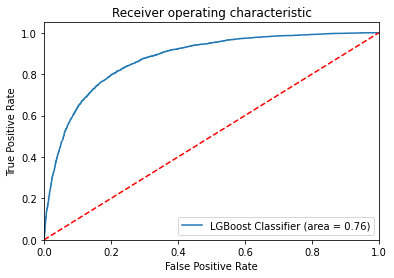

In [96]:
# Plotting the ROC_AUC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
lgbm_roc_auc = roc_auc_score(y_val, lgbm.predict(x_val))
fpr, tpr, thresholds = roc_curve(y_val, lgbm.predict_proba(x_val)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='LGBoost Classifier (area = %0.2f)' % lgbm_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('XGB_CV_ROC')
plt.show()

In [97]:
df_test_LGBM = X_test.copy()
df_test_LGBM["Outcome"] = y_test_lgbm_cv
df_test_LGBM = df_test_LGBM.loc[:,["Patient_ID","Health_Camp_ID","Outcome"]]

In [99]:
df_test_LGBM.to_csv("df_test_LGBM_gg11.csv", sep=",",index=False)

In [100]:
df_test_LGBM

,Patient_ID,Health_Camp_ID,Outcome
0,516956,6568,0.384291
1,508307,6574,0.793575
2,508307,6573,0.451449
3,508307,6551,0.633033
4,508307,6584,0.529101
...,...,...,...
35244,502431,6577,0.669109
35245,502431,6576,0.706910
35246,509515,6576,0.695903
35247,510713,6576,0.754622
